<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/minyak_goreng_merk2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [ ]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import math

from keras.utils.vis_utils import plot_model
from tensorflow.data import Dataset
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

## time step generator

In [ ]:
def time_step_generator(data, time_size, batch_size, shuffle_data):
  dataset = Dataset.from_tensor_slices(data)
  dataset = dataset.window(time_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(time_size+1))
  dataset = dataset.shuffle(shuffle_data)
  dataset = dataset.map(lambda x: (x[:-1], x[-1]))
  return dataset.batch(batch_size).prefetch(1)

def forecast_predict(model, data, time_size, batch_size):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

## Load data

In [ ]:
url ='https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_new.csv?raw=true'
urllib.request.urlretrieve(url, 'data_pangan.csv')

('data_pangan.csv', <http.client.HTTPMessage at 0x7f4f00741fa0>)

In [ ]:
dataset = pd.read_csv('data_pangan.csv')
dataset.head()

,date,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam_ras_segar,daging_sapi_kualitas_1,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
0,2017-01-08,11200,10150,9650,11250,11150,12750,12250,34100,118400,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
1,2017-01-11,11400,10350,9900,11500,11300,12900,12350,30350,117000,...,30000,30000,30450,13900,12250,14950,14300,14500,16550,12900
2,2017-01-12,10700,9650,8500,11200,10950,12250,11850,29350,115800,...,33300,31500,35050,14000,12150,15400,14400,14800,16650,12950
3,2017-02-08,11200,10150,9650,11250,11150,12750,12250,34150,118400,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
4,2017-02-10,11400,10250,9850,11400,11250,12850,12350,30200,118400,...,31850,32550,31550,14000,12350,15000,14350,14700,16750,12950


In [ ]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [ ]:
dataset = dataset.set_index('date')
dataset = dataset.sort_index()
train = dataset.minyak_goreng_kemasan_bermerk_2.values
date = dataset.index

## Train test val split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train, date, test_size=0.2, random_state=False, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=False, shuffle=False) # 0.125 x 0.48 = 0.1

print(f'{len(x_train)}\n{len(x_test)}')

818
234


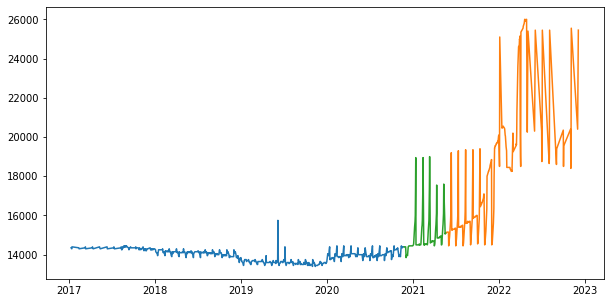

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_train, x_train)
plt.plot(y_test, x_test)
plt.plot(y_val, x_val)
plt.show()

## data generate

In [ ]:
scal_range= MinMaxScaler(feature_range=(0,1))
train_scal = scal_range.fit_transform(x_train.reshape(-1, 1))
test_scal = scal_range.fit_transform(x_test.reshape(-1, 1))
val_scal = scal_range.fit_transform(x_val.reshape(-1, 1))
train_step = time_step_generator(train_scal, time_size=600, shuffle_data=100, batch_size=5)
val_step = time_step_generator(val_scal, time_size=80, shuffle_data=100, batch_size=20)
test_step = time_step_generator(test_scal, time_size=150, shuffle_data=1000, batch_size=5)

train_step1 = time_step_generator(train_scal, time_size=100, shuffle_data=100, batch_size=1)
val_step1 = time_step_generator(val_scal, time_size=1, shuffle_data=10, batch_size=1)
test_step1 = time_step_generator(test_scal, time_size=10, shuffle_data=100, batch_size=1)

train_step2 = time_step_generator(train_scal, time_size=400, shuffle_data=1000, batch_size=5)
val_step2 = time_step_generator(val_scal, time_size=50, shuffle_data=100, batch_size=2)
test_step2 = time_step_generator(test_scal, time_size=100, shuffle_data=1000, batch_size=5)

In [ ]:
forecast = np.append(x_train, x_test)
forecast_date = np.append(y_train, y_test)
win_size= 400
win_size1 = 60
win_size2=150
test_minyakgoreng2_ = scal_range.fit_transform(forecast.reshape(-1, 1))

## model 

### SGD

In [ ]:
model= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
    LSTM(24, return_sequences=True),
    LSTM(20),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          48        
                                                                 
 lstm (LSTM)                 (None, None, 24)          3936      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3600      
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# plot_model(model, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

#### type1

In [ ]:
history = model.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 28s 434ms/step - loss: 0.0652 - mae: 0.2439 - mape: 91.6436 - val_loss: 0.0547 - val_mae: 0.1901 - val_mape: 74.2410
Epoch 2/30
44/44 [==============================] - 8s 188ms/step - loss: 0.0393 - mae: 0.1835 - mape: 66.9350 - val_loss: 0.0362 - val_mae: 0.1329 - val_mape: 45.9997
Epoch 3/30
44/44 [==============================] - 8s 186ms/step - loss: 0.0234 - mae: 0.1341 - mape: 46.9454 - val_loss: 0.0264 - val_mae: 0.0969 - val_mape: 30.7161
Epoch 4/30
44/44 [==============================] - 8s 187ms/step - loss: 0.0146 - mae: 0.0982 - mape: 33.3926 - val_loss: 0.0217 - val_mae: 0.0790 - val_mape: 25.4191
Epoch 5/30
44/44 [==============================] - 8s 181ms/step - loss: 0.0102 - mae: 0.0749 - mape: 25.0130 - val_loss: 0.0197 - val_mae: 0.0753 - val_mape: 26.2576
Epoch 6/30
44/44 [==============================] - 8s 186ms/step - loss: 0.0080 - mae: 0.0631 - mape: 21.5264 - val_loss: 0.0189 - val_mae: 0.0800 - val_mape:

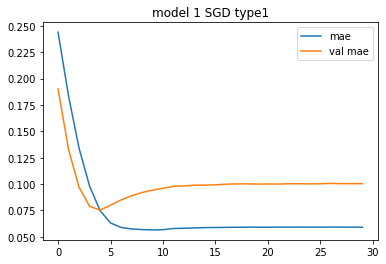

In [ ]:
mae = history.history['mae']
val_mae = history.history['val_mae']
epoch = range(len(mae))

plt.title('model 1 SGD type1')
plt.plot(epoch, mae, label='mae')
plt.plot(epoch, val_mae, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 4s 24ms/step
2538.7644 12.682803 3459.213783506304


,date,actual,prediction
0,2021-05-20,15100,16565.015625
1,2021-05-21,15100,16567.146484
2,2021-05-24,15150,16568.921875
3,2021-05-25,15150,16572.896484
4,2021-05-27,15150,16575.380859
...,...,...,...
229,2022-11-02,18400,16702.041016
230,2022-11-03,19550,16783.923828
231,2022-11-04,25550,16699.246094
232,2022-12-01,20400,16776.228516


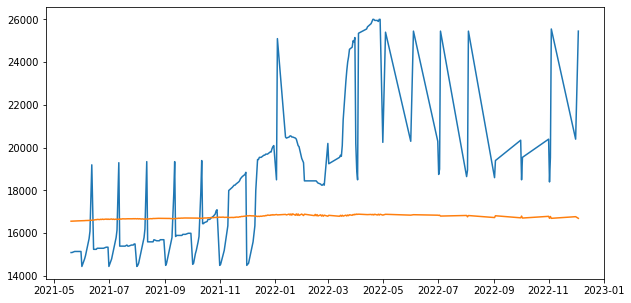

In [ ]:
prediction = forecast_predict(model, test_minyakgoreng2_, time_size=win_size, batch_size=5)

data_result = prediction[(len(x_train))-win_size:-1, -1 ]
data_result = scal_range.inverse_transform(data_result.reshape(-1, 1))
data_result = data_result.reshape(-1)
mae= tf.keras.metrics.mean_absolute_error(x_test, data_result)
mape = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result)
mse = tf.keras.metrics.mean_squared_error(x_test, data_result)

rmse =math.sqrt(mse.numpy())
print(mae.numpy(), mape.numpy(), rmse)

data_new_minyakgoreng2 = pd.DataFrame()
data_new_minyakgoreng2['date'] = y_test
data_new_minyakgoreng2['actual'] = x_test
data_new_minyakgoreng2['prediction'] = data_result
data_new_minyakgoreng2.to_csv('minyakgoreng2_model1_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(data_new_minyakgoreng2.date, data_new_minyakgoreng2.actual)
plt.plot(data_new_minyakgoreng2.date, data_new_minyakgoreng2.prediction)
data_new_minyakgoreng2

#### type2

In [ ]:
history_t1 = model.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 26s 36ms/step - loss: 0.0101 - mae: 0.0799 - mape: 422590.4062 - val_loss: 0.0187 - val_mae: 0.0839 - val_mape: 33.6041
Epoch 2/30
718/718 [==============================] - 25s 34ms/step - loss: 0.0098 - mae: 0.0793 - mape: 394391.5625 - val_loss: 0.0187 - val_mae: 0.0851 - val_mape: 34.4442
Epoch 3/30
718/718 [==============================] - 25s 35ms/step - loss: 0.0096 - mae: 0.0780 - mape: 413836.0312 - val_loss: 0.0188 - val_mae: 0.0833 - val_mape: 33.0583
Epoch 4/30
718/718 [==============================] - 25s 35ms/step - loss: 0.0094 - mae: 0.0778 - mape: 468664.5938 - val_loss: 0.0188 - val_mae: 0.0837 - val_mape: 33.3086
Epoch 5/30
718/718 [==============================] - 25s 35ms/step - loss: 0.0088 - mae: 0.0737 - mape: 404428.0312 - val_loss: 0.0188 - val_mae: 0.0852 - val_mape: 34.3939
Epoch 6/30
718/718 [==============================] - 27s 37ms/step - loss: 0.0086 - mae: 0.0729 - mape: 461831.3438 - val_loss: 0

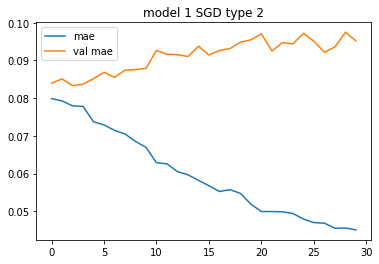

In [ ]:
mae_t1 = history_t1.history['mae']
val_mae_t1 = history_t1.history['val_mae']
epoch_t1 = range(len(mae_t1))

plt.title('model 1 SGD type 2')
plt.plot(epoch_t1, mae_t1, label='mae')
plt.plot(epoch_t1, val_mae_t1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 2s 8ms/step
1726.8046 8.311092 2683.121037150579


,date,actual,prediction
0,2021-05-20,15100,16565.015625
1,2021-05-21,15100,16567.146484
2,2021-05-24,15150,16568.921875
3,2021-05-25,15150,16572.896484
4,2021-05-27,15150,16575.380859
...,...,...,...
229,2022-11-02,18400,16702.041016
230,2022-11-03,19550,16783.923828
231,2022-11-04,25550,16699.246094
232,2022-12-01,20400,16776.228516


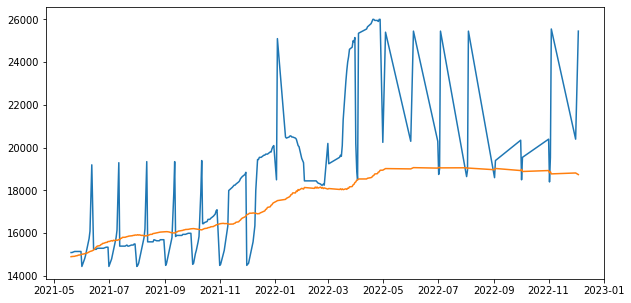

In [ ]:
win_size1 = 60
test_minyakgoreng2_1 = scal_range.fit_transform(forecast.reshape(-1, 1))
prediction_1 = forecast_predict(model, test_minyakgoreng2_1, time_size=win_size1, batch_size=5)

data_result_1 = prediction_1[(len(x_train))-win_size1:-1, -1 ]
data_result_1 = scal_range.inverse_transform(data_result_1.reshape(-1, 1))
data_result_1 = data_result_1.reshape(-1)
mae_1= tf.keras.metrics.mean_absolute_error(x_test, data_result_1)
mape_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_1)
mse_1 = tf.keras.metrics.mean_squared_error(x_test, data_result_1)
rmse_1 =math.sqrt(mse_1.numpy())
print(mae_1.numpy(), mape_1.numpy(), rmse_1)

data_new_minyakgoreng2_1 = pd.DataFrame()
data_new_minyakgoreng2_1['actual'] = x_test
data_new_minyakgoreng2_1['prediction'] = data_result_1
data_new_minyakgoreng2_1.to_csv('minyakgoreng2_model1_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_minyakgoreng2_1.actual)
plt.plot(y_test, data_new_minyakgoreng2_1.prediction)
data_new_minyakgoreng2

#### type3

In [ ]:
history_t2 = model.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 13s 151ms/step - loss: 0.0070 - mae: 0.0591 - mape: 535703.9375 - val_loss: 0.0193 - val_mae: 0.0863 - val_mape: 34.6118
Epoch 2/30
84/84 [==============================] - 11s 134ms/step - loss: 0.0068 - mae: 0.0546 - mape: 471702.6250 - val_loss: 0.0194 - val_mae: 0.0855 - val_mape: 34.0420
Epoch 3/30
84/84 [==============================] - 12s 135ms/step - loss: 0.0068 - mae: 0.0546 - mape: 475554.7812 - val_loss: 0.0194 - val_mae: 0.0845 - val_mape: 33.2547
Epoch 4/30
84/84 [==============================] - 11s 129ms/step - loss: 0.0067 - mae: 0.0536 - mape: 454080.2812 - val_loss: 0.0194 - val_mae: 0.0855 - val_mape: 34.0018
Epoch 5/30
84/84 [==============================] - 12s 138ms/step - loss: 0.0067 - mae: 0.0541 - mape: 468270.8750 - val_loss: 0.0193 - val_mae: 0.0861 - val_mape: 34.4873
Epoch 6/30
84/84 [==============================] - 12s 141ms/step - loss: 0.0067 - mae: 0.0538 - mape: 466006.4062 - val_loss: 0.0193 

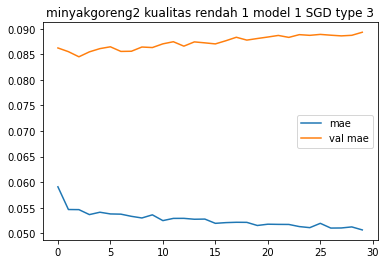

In [ ]:
mae_t2 = history_t2.history['mae']
val_mae_t2 = history_t2.history['val_mae']
epoch_t2 = range(len(mae_t2))

plt.title('minyakgoreng2 kualitas rendah 1 model 1 SGD type 3')
plt.plot(epoch_t2, mae_t2, label='mae')
plt.plot(epoch_t2, val_mae_t2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 2s 13ms/step
1660.033 7.9575143 2609.229004897807


,actual,prediction
0,15100,14473.818359
1,15100,14480.638672
2,15150,14489.840820
3,15150,14502.483398
4,15150,14515.483398
...,...,...
229,18400,19151.078125
230,19550,19192.876953
231,25550,19086.796875
232,20400,19124.203125


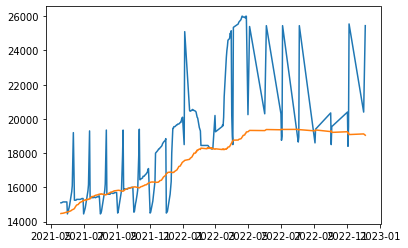

In [ ]:
win_size2 = 150
prediction_2 = forecast_predict(model, test_minyakgoreng2_, time_size=win_size2, batch_size=5)

data_result_2 = prediction_2[(len(x_train))-win_size2:-1, -1 ]
data_result_2 = scal_range.inverse_transform(data_result_2.reshape(-1, 1))
data_result_2 = data_result_2.reshape(-1)
mae_2= tf.keras.metrics.mean_absolute_error(x_test, data_result_2)
mape_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_2)
mse_2 = tf.keras.metrics.mean_squared_error(x_test, data_result_2)

rmse_2 =math.sqrt(mse_2.numpy())
print(mae_2.numpy(), mape_2.numpy(), rmse_2)

data_new_minyakgoreng2_2 = pd.DataFrame()
# data_new_minyakgoreng21['date'] = date_test
data_new_minyakgoreng2_2['actual'] = x_test
data_new_minyakgoreng2_2['prediction'] = data_result_2
data_new_minyakgoreng2_2.to_csv('minyakgoreng2_model1_sgd_type3')

plt.plot(y_test, data_new_minyakgoreng2_2.actual)
plt.plot(y_test, data_new_minyakgoreng2_2.prediction)
data_new_minyakgoreng2_2

### Adam

In [ ]:
model_a= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model_a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 16)          48        
                                                                 
 lstm_2 (LSTM)               (None, None, 24)          3936      
                                                                 
 lstm_3 (LSTM)               (None, 20)                3600      
                                                                 
 dense_2 (Dense)             (None, 64)                1344      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


#### Type 1

In [ ]:
history_a = model_a.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 15s 239ms/step - loss: 0.0592 - mae: 0.2315 - mape: 86.5114 - val_loss: 0.0498 - val_mae: 0.1765 - val_mape: 67.4637
Epoch 2/30
44/44 [==============================] - 9s 212ms/step - loss: 0.0303 - mae: 0.1586 - mape: 57.6730 - val_loss: 0.0251 - val_mae: 0.0913 - val_mape: 28.7680
Epoch 3/30
44/44 [==============================] - 9s 213ms/step - loss: 0.0071 - mae: 0.0646 - mape: 23.5079 - val_loss: 0.0204 - val_mae: 0.1106 - val_mape: 51.3781
Epoch 4/30
44/44 [==============================] - 9s 205ms/step - loss: 0.0054 - mae: 0.0585 - mape: 23.5418 - val_loss: 0.0198 - val_mae: 0.1054 - val_mape: 47.9700
Epoch 5/30
44/44 [==============================] - 10s 217ms/step - loss: 0.0052 - mae: 0.0554 - mape: 21.9417 - val_loss: 0.0199 - val_mae: 0.1063 - val_mape: 48.5710
Epoch 6/30
44/44 [==============================] - 9s 213ms/step - loss: 0.0053 - mae: 0.0554 - mape: 21.6665 - val_loss: 0.0204 - val_mae: 0.1105 - val_mape

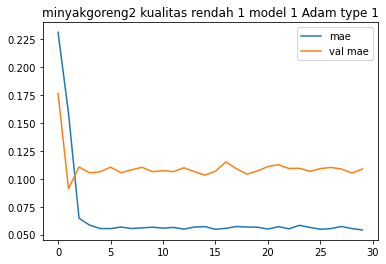

In [ ]:
mae_a = history_a.history['mae']
val_mae_a = history_a.history['val_mae']
epoch_a = range(len(mae_a))

plt.title('minyakgoreng2 kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a, mae_a, label='mae')
plt.plot(epoch_a, val_mae_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 4s 23ms/step
1768.0133 8.862203 2524.5802621426


,actual,prediction
0,15100,15736.230469
1,15100,15740.726562
2,15150,15749.550781
3,15150,15758.586914
4,15150,15770.014648
...,...,...
229,18400,19788.156250
230,19550,19752.277344
231,25550,19704.060547
232,20400,19663.267578


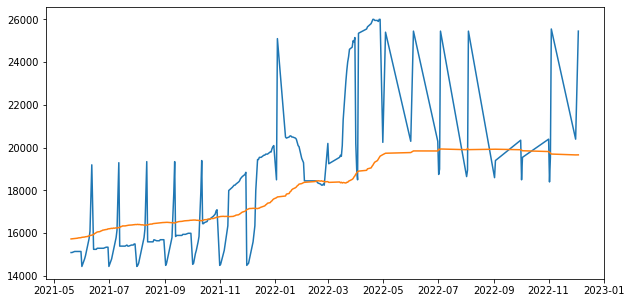

In [ ]:
prediction_a = forecast_predict(model_a, test_minyakgoreng2_, time_size=win_size, batch_size=5)

data_result_a = prediction_a[(len(x_train))-win_size:-1, -1 ]
data_result_a = scal_range.inverse_transform(data_result_a.reshape(-1, 1))
data_result_a = data_result_a.reshape(-1)
mae_a= tf.keras.metrics.mean_absolute_error(x_test, data_result_a)
mape_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a)
mse_a = tf.keras.metrics.mean_squared_error(x_test, data_result_a)

rmse_a =math.sqrt(mse_a.numpy())
print(mae_a.numpy(), mape_a.numpy(), rmse_a)

data_new_minyakgoreng2_a = pd.DataFrame()
# data_new_minyakgoreng21['date'] = date_test
data_new_minyakgoreng2_a['actual'] = x_test
data_new_minyakgoreng2_a['prediction'] = data_result_a
data_new_minyakgoreng2_a.to_csv('minyakgoreng2_model1_adam_type1.csv')

plt.figure(figsize=(10,5))
plt.plot(y_test, data_new_minyakgoreng2_a.actual)
plt.plot(y_test, data_new_minyakgoreng2_a.prediction)
data_new_minyakgoreng2_a

#### Type 2

In [ ]:
history_a1 = model_a.fit(train_step1, epochs=30, validation_data=val_step)

In [ ]:
mae_a1 = history_a1.history['mae']
val_mae_a1 = history_a1.history['val_mae']
epoch_a1 = range(len(mae_a1))

plt.title('minyakgoreng2 kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a1, mae_a1, label='mae')
plt.plot(epoch_a1, val_mae_a1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction_a1 = forecast_predict(model_a, test_minyakgoreng2_, time_size=win_size1, batch_size=5)

data_result_a1 = prediction_a1[(len(x_train))-win_size1:-1, -1 ]
data_result_a1 = scal_range.inverse_transform(data_result_a1.reshape(-1, 1))
data_result_a1 = data_result_a1.reshape(-1)
mae_a1= tf.keras.metrics.mean_absolute_error(x_test, data_result_a1)
mape_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a1)
mse_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result_a1)

rmse_a1 =math.sqrt(mse_a1.numpy())
print(mae_a1.numpy(), mape_a1.numpy(), rmse_a1)

data_new_minyakgoreng2_a1 = pd.DataFrame()
data_new_minyakgoreng2_a1['actual'] = x_test
data_new_minyakgoreng2_a1['prediction'] = data_result_a1
data_new_minyakgoreng2_a1.to_csv('minyakgoreng2_model1_adam_type2.csv')

plt.plot(y_test, data_new_minyakgoreng2_a1.actual)
plt.plot(y_test, data_new_minyakgoreng2_a1.prediction)
data_new_minyakgoreng2_a1

#### Type 3

In [ ]:
history_a2 = model_a.fit(train_step2, epochs=30, validation_data=val_step)

In [ ]:
mae_a2 = history_a2.history['mae']
val_mae_a2 = history_a2.history['val_mae']
epoch_a2 = range(len(mae_a2))

plt.title('minyakgoreng2 kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a2, mae_a2, label='mae')
plt.plot(epoch_a2, val_mae_a2, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction_a2 = forecast_predict(model_a, test_minyakgoreng2_, time_size=win_size2, batch_size=5)

data_result_a2 = prediction_a2[(len(x_train))-win_size2:-1, -1 ]
data_result_a2 = scal_range.inverse_transform(data_result_a2.reshape(-1, 1))
data_result_a2 = data_result_a2.reshape(-1)
mae_a2= tf.keras.metrics.mean_absolute_error(x_test, data_result_a2)
mape_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a2)
mse_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result_a2)

rmse_a2 =math.sqrt(mse_a2.numpy())
print(mae_a2.numpy(), mape_a2.numpy(), rmse_a2)

data_new_minyakgoreng2_a2 = pd.DataFrame()
# data_new_minyakgoreng21['date'] = date_test
data_new_minyakgoreng2_a2['actual'] = x_test
data_new_minyakgoreng2_a2['prediction'] = data_result_a2
data_new_minyakgoreng2_a2.to_csv('minyakgoreng2_model1_adam_type3.csv')

plt.plot(y_test, data_new_minyakgoreng2_a2.actual)
plt.plot(y_test, data_new_minyakgoreng2_a2.prediction)
data_new_minyakgoreng2_a2

## model 1

### Adam

In [ ]:
model1= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae', 'mape'])
model1.summary()

#### Type 1

In [ ]:
history1 = model1.fit(train_step, epochs=15, validation_data=val_step)

In [ ]:
model1.evaluate(test_step)
mae1 = history1.history['mae']
val_mae1 = history1.history['val_mae']
epoch1 = range(len(mae1))

plt.figure(figsize=(10, 5))
plt.plot(epoch1, mae1, label='mae')
plt.plot(epoch1, val_mae1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction1 = forecast_predict(model1, test_minyakgoreng2_, time_size=win_size, batch_size=5)

data_result1 = prediction1[(len(x_train))-win_size:-1, -1 ]
data_result1 = scal_range.inverse_transform(data_result1.reshape(-1, 1))
data_result1 = data_result1.reshape(-1)
mae1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1)
mape1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1)
mse1 = tf.keras.metrics.mean_squared_error(x_test, data_result1)

rmse1 = math.sqrt(mse1.numpy())
print(mae1.numpy(), mape1.numpy(), rmse1)

data_new_minyakgoreng21 = pd.DataFrame()
data_new_minyakgoreng21['actual'] = x_test
data_new_minyakgoreng21['prediction'] = data_result1
data_new_minyakgoreng21.to_csv('minyakgoreng2_model2_adam_type1.csv')

data_new_minyakgoreng21

In [ ]:
plt.figure(figsize=(40, 10))
plt.plot(range(len(x_test)), data_new_minyakgoreng21['actual'], '-o')
plt.plot(range(len(x_test)), data_new_minyakgoreng21['prediction'], '-o')

#### Type 2

In [ ]:
history1_1 = model1.fit(train_step1, epochs=15, validation_data=val_step)

In [ ]:
mae1_1 = history1_1.history['mae']
val_mae1_1 = history1_1.history['val_mae']
epoch1_1 = range(len(mae1_1))

plt.plot(epoch1_1, mae1_1, label='mae')
plt.plot(epoch1_1, val_mae1_1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction1_1 = forecast_predict(model1, test_minyakgoreng2_, time_size=win_size1, batch_size=5)

data_result1_1 = prediction1_1[(len(x_train))-win_size1:-1, -1 ]
data_result1_1 = scal_range.inverse_transform(data_result1_1.reshape(-1, 1))
data_result1_1 = data_result1_1.reshape(-1)
mae1_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_1)
mape1_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_1)
mse1_1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_1)

rmse1_1 = math.sqrt(mse1.numpy())
print(mae1_1.numpy(), mape1_1.numpy(), rmse1_1)

data_new_minyakgoreng21_1 = pd.DataFrame()
data_new_minyakgoreng21_1['actual'] = x_test
data_new_minyakgoreng21_1['prediction'] = data_result1_1
data_new_minyakgoreng21_1.to_csv('minyakgoreng2_model2_adam_type2.csv')

plt.plot(y_test, data_new_minyakgoreng21_1.actual)
plt.plot(y_test, data_new_minyakgoreng21_1.prediction)
data_new_minyakgoreng21_1

#### Type 3

In [ ]:
history1_2 = model1.fit(train_step2, epochs=15, validation_data=val_step)

In [ ]:
mae1_2 = history1_2.history['mae']
val_mae1_2 = history1_2.history['val_mae']
epoch1_2 = range(len(mae1_2))

plt.plot(epoch1_2, mae1_2, label='mae')
plt.plot(epoch1_2, val_mae1_2, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction1_2 = forecast_predict(model1, test_minyakgoreng2_, time_size=win_size2, batch_size=5)

data_result1_2 = prediction1_2[(len(x_train))-win_size2:-1, -1 ]
data_result1_2 = scal_range.inverse_transform(data_result1_2.reshape(-1, 1))
data_result1_2 = data_result1_2.reshape(-1)
mae1_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_2)
mape1_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_2)
mse1_2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_2)
rmse1_2 = math.sqrt(mse1.numpy())
print(mae1_2.numpy(), mape1_2.numpy(), rmse1_2)

data_new_minyakgoreng21_2 = pd.DataFrame()
data_new_minyakgoreng21_2['actual'] = x_test
data_new_minyakgoreng21_2['prediction'] = data_result1_2
data_new_minyakgoreng21_2.to_csv('minyakgoreng2_model2_adam_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_minyakgoreng21_2.actual)
plt.plot(y_test, data_new_minyakgoreng21_2.prediction)

data_new_minyakgoreng21_2

### SGD

In [ ]:
model1_a= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1_a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model1_a.summary()

In [ ]:
# plot_model(model1, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

#### Type1 

In [ ]:
history1_a = model1_a.fit(train_step, epochs=15, validation_data=val_step)

In [ ]:
mae1_a = history1_a.history['mae']
val_mae1_a = history1_a.history['val_mae']
epoch1_a = range(len(mae1_a))

plt.plot(epoch1_a, mae1_a, label='mae')
plt.plot(epoch1_a, val_mae1_a, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction1_a = forecast_predict(model1_a, test_minyakgoreng2_, time_size=win_size, batch_size=5)

data_result1_a = prediction1_a[(len(x_train))-win_size:-1, -1 ]
data_result1_a = scal_range.inverse_transform(data_result1_a.reshape(-1, 1))
data_result1_a = data_result1_a.reshape(-1)
mae1_a = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a)
mape1_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a)
mse1_a = tf.keras.metrics.mean_squared_error(x_test, data_result1_a)

rmse1_a = math.sqrt(mse1_a.numpy())
print(mae1_a.numpy(), mape1_a.numpy(), rmse1_a)

data_new_minyakgoreng21_a = pd.DataFrame()
data_new_minyakgoreng21_a['actual'] = x_test
data_new_minyakgoreng21_a['prediction'] = data_result1_a
data_new_minyakgoreng21_a.to_csv('minyakgoreng2_model2_sgd_type1.csv')


plt.plot(y_test, data_new_minyakgoreng21_a.actual)
plt.plot(y_test, data_new_minyakgoreng21_a.prediction)

data_new_minyakgoreng21_a

#### Type 2


In [ ]:
history1_a1 = model1_a.fit(train_step1, epochs=15, validation_data=val_step)

In [ ]:
mae1_a1 = history1_a1.history['mae']
val_mae1_a1 = history1_a1.history['val_mae']
epoch1_a1 = range(len(mae1_a1))

plt.plot(epoch1_a1, mae1_a1, label='mae')
plt.plot(epoch1_a1, val_mae1_a1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction1_a1 = forecast_predict(model1_a, test_minyakgoreng2_, time_size=win_size1, batch_size=5)

data_result1_a1 = prediction1_a1[(len(x_train))-win_size1:-1, -1 ]
data_result1_a1 = scal_range.inverse_transform(data_result1_a1.reshape(-1, 1))
data_result1_a1 = data_result1_a1.reshape(-1)
mae1_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a1)
mape1_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a1)
mse1_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a1)

rmse1_a1 = math.sqrt(mse1_a1.numpy())
print(mae1_a1.numpy(), mape1_a1.numpy(), rmse1_a1)

data_new_minyakgoreng21_a1 = pd.DataFrame()
data_new_minyakgoreng21_a1['actual'] = x_test
data_new_minyakgoreng21_a1['prediction'] = data_result1_a1
data_new_minyakgoreng21_a1.to_csv('minyakgoreng2_model2_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_minyakgoreng21_a1.actual)
plt.plot(y_test, data_new_minyakgoreng21_a1.prediction)
data_new_minyakgoreng21_a1

#### Type 3

In [ ]:
history1_a2 = model1_a.fit(train_step2, epochs=15, validation_data=val_step)

In [ ]:
mae1_a2 = history1_a2.history['mae']
val_mae1_a2 = history1_a2.history['val_mae']
epoch1_a2 = range(len(mae1_a2))

plt.plot(epoch1_a2, mae1_a2, label='mae')
plt.plot(epoch1_a2, val_mae1_a2, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction1_a2 = forecast_predict(model1_a, test_minyakgoreng2_, time_size=win_size2, batch_size=5)

data_result1_a2 = prediction1_a2[(len(x_train))-win_size2:-1, -1 ]
data_result1_a2 = scal_range.inverse_transform(data_result1_a2.reshape(-1, 1))
data_result1_a2 = data_result1_a2.reshape(-1)
mae1_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a2)
mape1_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a2)
mse1_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a2)

rmse1_a2 = math.sqrt(mse1_a2.numpy())
print(mae1_a2.numpy(), mape1_a2.numpy(), rmse1_a2)

data_new_minyakgoreng21_a2 = pd.DataFrame()
data_new_minyakgoreng21_a2['actual'] = x_test
data_new_minyakgoreng21_a2['prediction'] = data_result1_a2
data_new_minyakgoreng21_a2.to_csv('minyakgoreng2_model2_sgd_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_minyakgoreng21_a2.actual)
plt.plot(y_test, data_new_minyakgoreng21_a2.prediction)

data_new_minyakgoreng21_a2

## model 2

### SGD

In [ ]:
model2= Sequential([
    Conv1D(8, kernel_size=5, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(14, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(24, activation='relu'),
    Dense(550, activation='relu'),
    Dense(1)
])

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model2.summary()

In [ ]:
# plot_model(model2, to_file='model3_plot.png', show_shapes=True, show_layer_names=True)

#### Type 1

In [ ]:
history2 = model2.fit(train_step, epochs=50, validation_data=val_step)

In [ ]:
mae2 = history2.history['mae']
val_mae2 = history2.history['val_mae']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epoch2 = range(len(mae2))

plt.figure(figsize=(20, 5))
plt.subplot(1,2, 1)
plt.plot(epoch2, mae2, label='mae')
plt.plot(epoch2, val_mae2, label='val mae')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch2, loss2, label='loss')
plt.plot(epoch2, val_loss2, label='val loss')
plt.legend()
plt.show()

In [ ]:
prediction2 = forecast_predict(model2, test_minyakgoreng2_, time_size=win_size, batch_size=5)

data_result2 = prediction2[(len(x_train))-win_size:-1, -1 ]
data_result2 = scal_range.inverse_transform(data_result2.reshape(-1, 1))
data_result2 = data_result2.reshape(-1)
mae2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2)
mape2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2)
mse2 = tf.keras.metrics.mean_squared_error(x_test, data_result2)

rmse2 = math.sqrt(mse2.numpy())
print(mae2.numpy(), mape2.numpy(), rmse2)

data_new_minyakgoreng22 = pd.DataFrame()
data_new_minyakgoreng22['actual'] = x_test
data_new_minyakgoreng22['prediction'] = data_result2
data_new_minyakgoreng22.to_csv('minyakgoreng2_medium_model3_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_minyakgoreng22.actual)
plt.plot(y_test, data_new_minyakgoreng22.prediction)
data_new_minyakgoreng22

#### Type2

In [ ]:
history2_1 = model2.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 12s 17ms/step - loss: 0.0117 - mae: 0.0875 - mape: 525337.0000 - val_loss: 0.0191 - val_mae: 0.0764 - val_mape: 27.8631
Epoch 2/50
718/718 [==============================] - 12s 17ms/step - loss: 0.0114 - mae: 0.0887 - mape: 430618.0625 - val_loss: 0.0190 - val_mae: 0.0777 - val_mape: 28.9171
Epoch 3/50
718/718 [==============================] - 12s 17ms/step - loss: 0.0113 - mae: 0.0883 - mape: 469190.5000 - val_loss: 0.0189 - val_mae: 0.0779 - val_mape: 29.1020
Epoch 4/50
718/718 [==============================] - 12s 17ms/step - loss: 0.0111 - mae: 0.0866 - mape: 482748.1250 - val_loss: 0.0190 - val_mae: 0.0777 - val_mape: 28.9342
Epoch 5/50
718/718 [==============================] - 12s 16ms/step - loss: 0.0110 - mae: 0.0868 - mape: 435854.5312 - val_loss: 0.0190 - val_mae: 0.0776 - val_mape: 28.8510
Epoch 6/50
718/718 [==============================] - 12s 17ms/step - loss: 0.0110 - mae: 0.0863 - mape: 475530.0312 - val_loss: 0

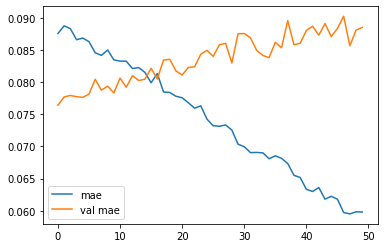

In [ ]:
mae2_1 = history2_1.history['mae']
val_mae2_1 = history2_1.history['val_mae']
epoch2_1 = range(len(mae2_1))

plt.plot(epoch2_1, mae2_1, label='mae')
plt.plot(epoch2_1, val_mae2_1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_1 = forecast_predict(model2, test_minyakgoreng2_, time_size=win_size1, batch_size=5)

data_result2_1 = prediction2_1[(len(x_train))-win_size1:-1, -1 ]
data_result2_1 = scal_range.inverse_transform(data_result2_1.reshape(-1, 1))
data_result2_1 = data_result2_1.reshape(-1)
mae2_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_1)
mape2_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_1)
mse2_1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_1)

rmse2_1 = math.sqrt(mse2_1.numpy())
print(mae2_1.numpy(), mape2_1.numpy(), rmse2_1)

data_new_minyakgoreng22_1 = pd.DataFrame()
data_new_minyakgoreng22_1['actual'] = x_test
data_new_minyakgoreng22_1['prediction'] = data_result2_1
data_new_minyakgoreng22_1.to_csv('minyakgoreng2_model3_sgd_type2.csv')

data_new_minyakgoreng22

199/199 [==============================] - 1s 4ms/step
2167.147 10.465735 3201.338313893113


,actual,prediction
0,15100,16660.630859
1,15100,16661.480469
2,15150,16662.107422
3,15150,16660.396484
4,15150,16661.779297
...,...,...
229,18400,16850.873047
230,19550,16850.646484
231,25550,16850.966797
232,20400,16844.085938


#### Type 3

In [ ]:
history2_2 = model2.fit(train_step2, epochs=50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 6s 69ms/step - loss: 0.0102 - mae: 0.0788 - mape: 773768.5000 - val_loss: 0.0192 - val_mae: 0.0777 - val_mape: 28.5668
Epoch 2/50
84/84 [==============================] - 6s 66ms/step - loss: 0.0094 - mae: 0.0740 - mape: 696045.7500 - val_loss: 0.0198 - val_mae: 0.0751 - val_mape: 26.1663
Epoch 3/50
84/84 [==============================] - 6s 67ms/step - loss: 0.0094 - mae: 0.0737 - mape: 668719.8750 - val_loss: 0.0200 - val_mae: 0.0748 - val_mape: 25.7059
Epoch 4/50
84/84 [==============================] - 6s 66ms/step - loss: 0.0093 - mae: 0.0731 - mape: 637745.2500 - val_loss: 0.0200 - val_mae: 0.0748 - val_mape: 25.5680
Epoch 5/50
84/84 [==============================] - 6s 67ms/step - loss: 0.0092 - mae: 0.0724 - mape: 619243.4375 - val_loss: 0.0200 - val_mae: 0.0748 - val_mape: 25.5669
Epoch 6/50
84/84 [==============================] - 6s 66ms/step - loss: 0.0092 - mae: 0.0724 - mape: 640288.5000 - val_loss: 0.0200 - val_mae: 0

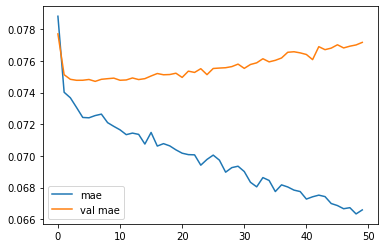

In [ ]:
mae2_2 = history2_2.history['mae']
val_mae2_2 = history2_2.history['val_mae']
epoch2_2 = range(len(mae2_2))

plt.plot(epoch2_2, mae2_2, label='mae')
plt.plot(epoch2_2, val_mae2_2, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_2 = forecast_predict(model2, test_minyakgoreng2_, time_size=win_size2, batch_size=5)

data_result2_2 = prediction2_2[(len(x_train))-win_size2:-1, -1 ]
data_result2_2 = scal_range.inverse_transform(data_result2_2.reshape(-1, 1))
data_result2_2 = data_result2_2.reshape(-1)
mae2_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_2)
mape2_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_2)
mse2_2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_2)

rmse2_2 = math.sqrt(mse2_2.numpy())
print(mae2_2.numpy(), mape2_2.numpy(), rmse2_2)

data_new_minyakgoreng22_2 = pd.DataFrame()
data_new_minyakgoreng22_2['actual'] = x_test
data_new_minyakgoreng22_2['prediction'] = data_result2_2
data_new_minyakgoreng22_2.to_csv('minyakgoreng2_model3_sgd-type3.csv')

data_new_minyakgoreng22_2

181/181 [==============================] - 1s 7ms/step
2092.9968 9.933676 3199.4924597504523


,actual,prediction
0,15100,14841.220703
1,15100,14841.111328
2,15150,14842.186523
3,15150,14843.394531
4,15150,14848.036133
...,...,...
229,18400,17633.072266
230,19550,17590.437500
231,25550,17610.128906
232,20400,17609.603516


### Adam

In [ ]:
model2_a= Sequential([
    Conv1D(16, kernel_size=2, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(24, return_sequences=True),
    Dropout(0.3),
    LSTM(80),
    Dense(24, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

model2_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model2_a.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, None, 16)          48        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 lstm_10 (LSTM)              (None, None, 24)          3936      
                                                                 
 dropout_1 (Dropout)         (None, None, 24)          0         
                                                                 
 lstm_11 (LSTM)              (None, 80)                33600     
                                                                 
 dense_13 (Dense)            (None, 24)                1944      
                                                      

#### type 1

In [ ]:
history2_a = model2_a.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 9s 125ms/step - loss: 0.0631 - mae: 0.2395 - mape: 89.7444 - val_loss: 0.0505 - val_mae: 0.1787 - val_mape: 68.5750
Epoch 2/50
44/44 [==============================] - 5s 107ms/step - loss: 0.0209 - mae: 0.1240 - mape: 47.5977 - val_loss: 0.0190 - val_mae: 0.0813 - val_mape: 31.1062
Epoch 3/50
44/44 [==============================] - 5s 104ms/step - loss: 0.0055 - mae: 0.0548 - mape: 21.3203 - val_loss: 0.0190 - val_mae: 0.0819 - val_mape: 31.5335
Epoch 4/50
44/44 [==============================] - 5s 104ms/step - loss: 0.0053 - mae: 0.0547 - mape: 21.3763 - val_loss: 0.0188 - val_mae: 0.0853 - val_mape: 34.1905
Epoch 5/50
44/44 [==============================] - 5s 105ms/step - loss: 0.0058 - mae: 0.0583 - mape: 23.2755 - val_loss: 0.0188 - val_mae: 0.0853 - val_mape: 34.2089
Epoch 6/50
44/44 [==============================] - 5s 105ms/step - loss: 0.0059 - mae: 0.0578 - mape: 22.8643 - val_loss: 0.0189 - val_mae: 0.0841 - val_mape: 

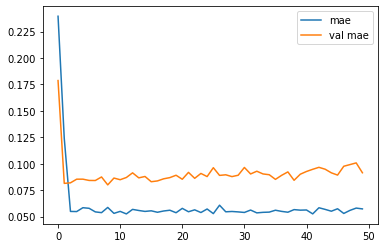

In [ ]:
mae2_a = history2_a.history['mae']
val_mae2_a = history2_a.history['val_mae']
epoch2_a = range(len(mae2_a))

plt.plot(epoch2_a, mae2_a, label='mae')
plt.plot(epoch2_a, val_mae2_a, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_a = forecast_predict(model2_a, test_minyakgoreng2_, time_size=win_size, batch_size=5)

data_result2_a = prediction2_a[(len(x_train))-win_size:-1, -1 ]
data_result2_a = scal_range.inverse_transform(data_result2_a.reshape(-1, 1))
data_result2_a = data_result2_a.reshape(-1)
mae2_a = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a)
mape2_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a)
mse2_a = tf.keras.metrics.mean_squared_error(x_test, data_result2_a)

rmse2_a = math.sqrt(mse2_a.numpy())
print(mae2_a.numpy(), mape2_a.numpy(), rmse2_a)

data_new_minyakgoreng22_a = pd.DataFrame()
data_new_minyakgoreng22_a['actual'] = x_test
data_new_minyakgoreng22_a['prediction'] = data_result2_a
data_new_minyakgoreng22_a.to_csv('minyakgoreng2_model3_adam-type1.csv')

data_new_minyakgoreng22_a

131/131 [==============================] - 2s 13ms/step
1943.5745 9.568771 2833.558804754191


,actual,prediction
0,15100,15816.343750
1,15100,15821.806641
2,15150,15822.007812
3,15150,15830.427734
4,15150,15830.472656
...,...,...
229,18400,18947.003906
230,19550,18950.314453
231,25550,19098.041016
232,20400,19010.335938


#### Type 2

In [ ]:
history2_a1 = model2_a.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 13s 18ms/step - loss: 0.0063 - mae: 0.0563 - mape: 396061.9062 - val_loss: 0.0193 - val_mae: 0.0958 - val_mape: 41.3721
Epoch 2/50
718/718 [==============================] - 13s 18ms/step - loss: 0.0055 - mae: 0.0509 - mape: 302369.0625 - val_loss: 0.0199 - val_mae: 0.1036 - val_mape: 46.5326
Epoch 3/50
718/718 [==============================] - 13s 19ms/step - loss: 0.0051 - mae: 0.0472 - mape: 233066.2344 - val_loss: 0.0220 - val_mae: 0.1201 - val_mape: 57.1940
Epoch 4/50
718/718 [==============================] - 13s 18ms/step - loss: 0.0050 - mae: 0.0465 - mape: 265498.6875 - val_loss: 0.0278 - val_mae: 0.1465 - val_mape: 73.8663
Epoch 5/50
718/718 [==============================] - 13s 18ms/step - loss: 0.0049 - mae: 0.0452 - mape: 243759.9844 - val_loss: 0.0222 - val_mae: 0.1178 - val_mape: 55.5825
Epoch 6/50
718/718 [==============================] - 13s 18ms/step - loss: 0.0048 - mae: 0.0441 - mape: 222556.1250 - val_loss: 0

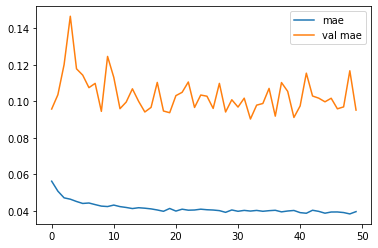

In [ ]:
mae2_a1 = history2_a1.history['mae']
val_mae2_a1 = history2_a1.history['val_mae']
epoch2_a1 = range(len(mae2_a1))

plt.plot(epoch2_a1, mae2_a1, label='mae')
plt.plot(epoch2_a1, val_mae2_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
1552.5251 7.65643 2272.7603261232803


,actual,prediction
0,15100,14517.206055
1,15100,14503.248047
2,15150,14543.487305
3,15150,14540.425781
4,15150,14561.916992
...,...,...
229,18400,20785.164062
230,19550,20638.472656
231,25550,20985.861328
232,20400,20658.441406


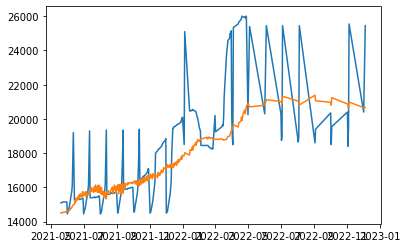

In [ ]:
prediction2_a1 = forecast_predict(model2_a, test_minyakgoreng2_, time_size=win_size1, batch_size=5)

data_result2_a1 = prediction2_a1[(len(x_train))-win_size1:-1, -1 ]
data_result2_a1 = scal_range.inverse_transform(data_result2_a1.reshape(-1, 1))
data_result2_a1 = data_result2_a1.reshape(-1)
mae2_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a1)
mape2_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a1)
mse2_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a1)

rmse2_a1 = math.sqrt(mse2_a1.numpy())
print(mae2_a1.numpy(), mape2_a1.numpy(), rmse2_a1)

data_new_minyakgoreng22_a1 = pd.DataFrame()
data_new_minyakgoreng22_a1['actual'] = x_test
data_new_minyakgoreng22_a1['prediction'] = data_result2_a1
data_new_minyakgoreng22_a1.to_csv('minyakgoreng2_model3_adam-type2.csv')

plt.plot(y_test, data_new_minyakgoreng22_a1.actual)
plt.plot(y_test, data_new_minyakgoreng22_a1.prediction)
data_new_minyakgoreng22_a1

#### Type 3

In [ ]:
history2_a2 = model2_a.fit(train_step2, epochs= 50, validation_data=val_step)

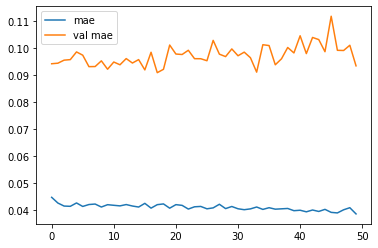

In [ ]:
mae2_a2 = history2_a2.history['mae']
val_mae2_a2 = history2_a2.history['val_mae']
epoch2_a2 = range(len(mae2_a2))

plt.plot(epoch2_a2, mae2_a2, label='mae')
plt.plot(epoch2_a2, val_mae2_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 7ms/step
1639.1107 8.230373 2326.8629095844904


,actual,prediction
0,15100,16282.584961
1,15100,16240.188477
2,15150,16269.487305
3,15150,16241.068359
4,15150,16259.600586
...,...,...
229,18400,20679.207031
230,19550,20398.017578
231,25550,20312.925781
232,20400,20189.943359


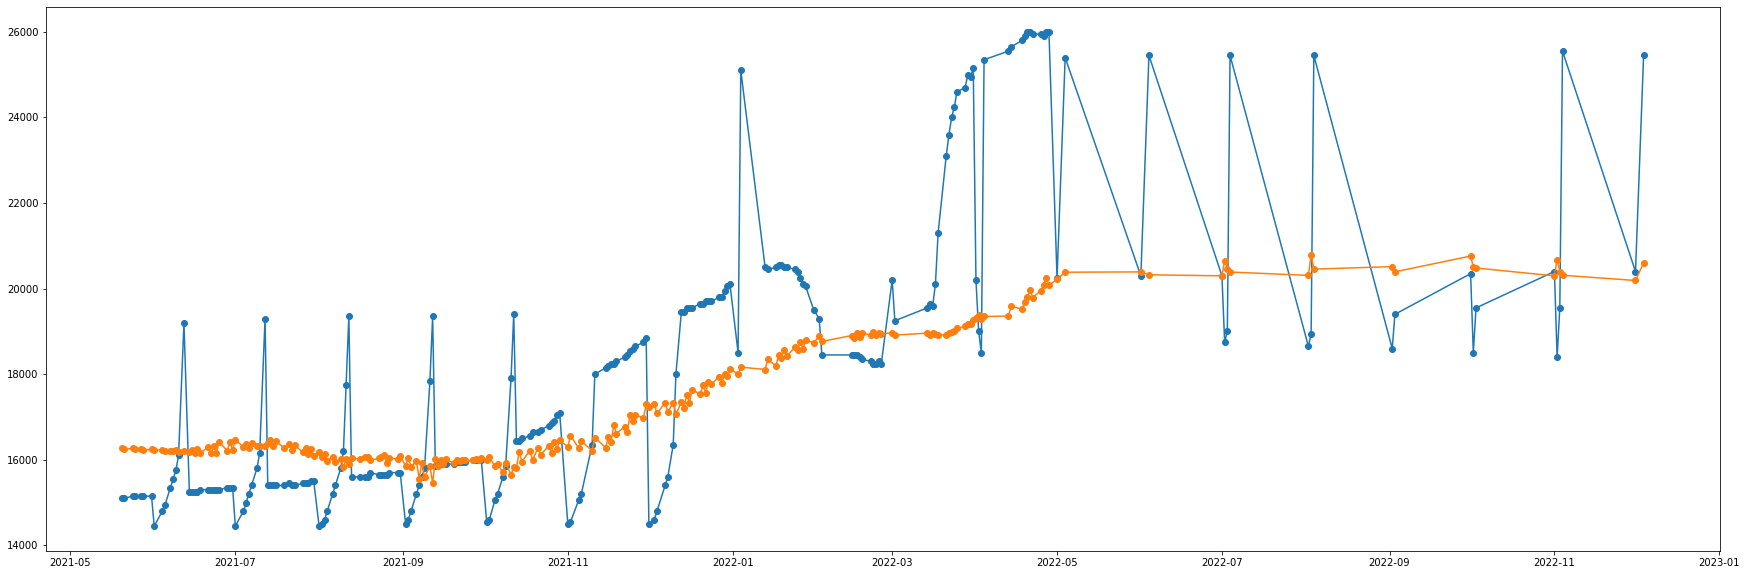

In [77]:
prediction2_a2 = forecast_predict(model2_a, test_minyakgoreng2_, time_size=win_size2, batch_size=5)

data_result2_a2 = prediction2_a2[(len(x_train))-win_size2:-1, -1 ]
data_result2_a2 = scal_range.inverse_transform(data_result2_a2.reshape(-1, 1))
data_result2_a2 = data_result2_a2.reshape(-1)
mae2_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a2)
mape2_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a2)
mse2_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a2)

rmse2_a2 = math.sqrt(mse2_a2.numpy())
print(mae2_a2.numpy(), mape2_a2.numpy(), rmse2_a2)

data_new_minyakgoreng22_a2 = pd.DataFrame()
data_new_minyakgoreng22_a2['actual'] = x_test
data_new_minyakgoreng22_a2['prediction'] = data_result2_a2
data_new_minyakgoreng22_a2.to_csv('minyakgoreng2_model3_adam_type3.csv')

plt.figure(figsize=(30, 10))
plt.plot(y_test,data_new_minyakgoreng22_a2.actual, '-o')
plt.plot(y_test,data_new_minyakgoreng22_a2.prediction, '-o')
data_new_minyakgoreng22_a2